# Introdução

O **covid-cxr-test** é um projeto que visa identificar pessoas infectatas com a COVID-19 por meio de raio-x do Torax. A natureza do problema não é muito simples, tendo em vista que essa categorização pode variar de pessoa a pessoa. 

Nós propomos uma AI para:
- Identificar pacientes com COVID-19;
- Utilizar processamento de imagem para reconhecer/classificar infectados e não infectados


## Explicação Técnica

- Usamos uma Rede Neural Convolucional (CNN - Convolutional Neural Network)

As convoluções funcionam como filtros que enxergam pequenos quadrados e vão "caminhando" por toda a imagem captando os traços mais marcantes.

Uma convolução multiplica uma matriz de pixels com uma matriz de filtro ou 'kernel' e soma os valores de multiplicação. Em seguida, a convolução desliza para o próximo pixel e repete o mesmo processo até que todos os pixels da imagem tenham sido cobertos. 

<img src="assets/img/convolucoes.png" width="750" title="">


Nós utilizamos os dados **COVIDx CXR-2** disponibilizados no Kaggle para treinar o algoritmo utilizando o Keras.

# Instalando e importando as dependencias

In [18]:
%%capture
# remove the line above to get text output
!pip install --upgrade -r requirements.txt

In [30]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from sklearn import metrics

# Coleta e estruturação de dados

Nós criamos um bash script que organiza as imagens em suas respectivas pastas, segundo a estrutura do projeto.
A estrutura do projeto está disposta desta maneira:
```
├── dataset
│   ├── COVIDxCXR-2
│   ├── test
│   │   ├── negative
│   │   └── positive
│   └── train
│       ├── negative
│       └── positive
└── scripts
```
Para o correto funcionamento do script, descompacte o arquivo do dataset dentro do diretório `dataset`. (uma pasta COVIDxCXR-2 será o resultado desta extração)
Execute o script na raiz do repositório como indicado abaixo:
```
./scripts/organize_dataset.sh
```

*OBS: Certifique-se que o script e seu usuário tenham as permissões necessárias para a execução correta. O comando `chmod +x ./scripts/organize_dataset.sh` vai conceder a permissão necessária para que o script seja "executável".*

# Preprocessamento de dados



In [31]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train', # directory where the data is located
    labels="inferred", # will organize the data into two labels: 0 = negative, 1 = positive
    label_mode="int", 
    # class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256), # Size to resize images to after they are read from disk 
    shuffle=True, # To suffle the data
   # seed=None, 
    validation_split=None,
    # subset=None,
    interpolation="bilinear",
    follow_links=False,
)

print(dataset.__dict__.keys())
print(dataset._structure)

Found 4772 files belonging to 2 classes.
Found 400 images belonging to 2 classes.
dict_keys(['_input_dataset', '_batch_size', '_drop_remainder', '_structure', '_variant_tensor_attr', '_self_setattr_tracking', '_self_unconditional_checkpoint_dependencies', '_self_unconditional_dependency_names', '_self_unconditional_deferred_dependencies', '_self_update_uid', '_self_name_based_restores', '_self_saveable_object_factories', '_variant_tracker', '_graph_attr', '_options_attr', 'class_names', 'file_paths'])
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


# Diferença entre negativo e positivo
## Positivo
Após algumas análises, notamos que nos casos positivos há uma área ligeiramente mais escura no pulmão e maior opacidade. Essa caracteristica observada foi confirmada através de estudos, segundo a doutora Paula Cristina dos Santos USP, "o aumento na densidade do pulmão, que fica com "o aspecto de branco 'jateado', chamado na medicina de 'vidro fosco' é uma característica muito forte dos pacientes com a covid-19."

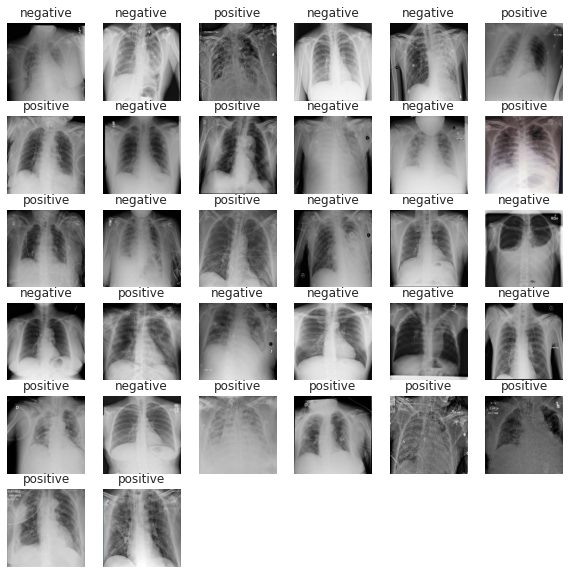

In [32]:
plt.figure(figsize=(10, 10))
class_names = dataset.class_names
for images, labels in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [33]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('dataset/train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 4772 images belonging to 2 classes.


<AxesSubplot:ylabel='count'>

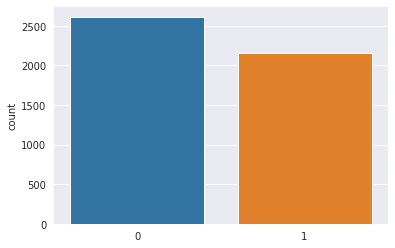

In [34]:
sns.set_style('darkgrid')
sns.countplot(x=training_set.classes)

In [35]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 400 images belonging to 2 classes.


####  

<AxesSubplot:ylabel='count'>

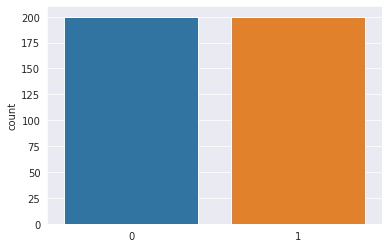

In [36]:
sns.set_style('darkgrid')
sns.countplot(x=test_set.classes)

# Creating and testing models

## Sequential

O tipo do modelo selecionado é o Sequencial, pois permite a criação do modelo passo a passo.


### Funcões de Ativação

Serve para garantir a não linearidade, permitindo que a rede consida aprender qualquer tipo de funcionalidade. Utilizamos a Relu, por ser mais eficiente computacionalmente já que estamos utilizando nossas máquinas pessois para o projeto.

As nossas primeiras Layers são Conv2D. Essas 


### Pooling

Uma camada de pooling serve para simplificar a informação da camada anterior. A unidade é responsável por resumir a informação daquela área em um único valor.


In [37]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[256, 256, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)       

# Recuperação do modelo
Caso o modelo já tenha sido treinado (e salvo!) alguma vez, ele será recuperado do disco na celula seguinte.

In [45]:
loaded_model = None
try:
    loaded_model = tf.keras.models.load_model('model/')
    cnn = loaded_model
except:
    pass


# Declarando funções de recall e precision

In [46]:
def recall(y_true, y_pred):
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
     recall = true_positives / (possible_positives + K.epsilon())
     return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Treinando o modelo
Na celula abaixo, o modelo só será treinado caso nenhum modelo tenha sido recuperado do disco.
Essa etapa de verificação é importante para que os resultados dos treinamentos que geralmente demandam um bom tempo de processamento possam ser recuperados do disco.

In [ ]:
if cnn == loaded_model:
    pass
else:
    cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', recall, precision])
    cnn_history = cnn.fit(x = training_set, validation_data = test_set, epochs = 10)

Epoch 1/10
150/150 [==============================] - 225s 1s/step - loss: 0.2978 - accuracy: 0.8755 - recall: 0.8757 - precision: 0.8596 - val_loss: 0.3850 - val_accuracy: 0.8375 - val_recall: 0.7306 - val_precision: 0.9373
Epoch 2/10
150/150 [==============================] - 232s 2s/step - loss: 0.2849 - accuracy: 0.8820 - recall: 0.8749 - precision: 0.8680 - val_loss: 0.2423 - val_accuracy: 0.9025 - val_recall: 0.8738 - val_precision: 0.9088
Epoch 3/10
150/150 [==============================] - 230s 2s/step - loss: 0.2810 - accuracy: 0.8835 - recall: 0.8649 - precision: 0.8682 - val_loss: 0.2537 - val_accuracy: 0.8950 - val_recall: 0.8890 - val_precision: 0.9038
Epoch 4/10
150/150 [==============================] - 232s 2s/step - loss: 0.2828 - accuracy: 0.8850 - recall: 0.8802 - precision: 0.8610 - val_loss: 0.2401 - val_accuracy: 0.9025 - val_recall: 0.9372 - val_precision: 0.8770
Epoch 5/10
  3/150 [..............................] - ETA: 4:00 - loss: 0.2685 - accuracy: 0.8542 - 

## Salvar o modelo
Caso o modelo tenha sido treinado na celula anterior, salva o modelo em disco na pasta `model/`.
Caso o modelo tenha sido carregado do disco, não faz nada.



In [42]:
if not loaded_model:
    cnn.save('model/')

INFO:tensorflow:Assets written to: model/assets


# Testes e Validação

Analizando os resultados obtidos, além da acurácia analizamos a precisão (proporção de acerto dentre os previstos como positivo) obtivemos bons resultados tendo em vista que ficou em: 

Já o resultado do recall (proporção de acerto dentre os positivos reais) obteve 

Isso significa que o modelo possui uma confiabilidade estável, mas que pode ser mais otimizado com mais dados para o treinamento.

In [44]:
plt.plot(cnn_history.history['accuracy'], label='accuracy')
plt.plot(cnn_history.history[recall], label = 'recall')
plt.plot(cnn_history.history[precision], label = 'precision')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

NameError: name 'history' is not defined

# Lições Aprendidas

- A coleta de dados deve ser feita com cuidado pois interfere e muito no resultado do modelo. primeiro testamos com  o dataset total coletado uma disparidade grande entre os dados de covid negativos em relação aos positivos. A acurácia era boa, mas ao analizar o recall e a precisão identificamos que por possuir mais dados negativos, o modelo estava tendendo a essa classificação. Ou seja é como se todos os resultados fossem negativos, independente da entrada.

<img src="assets/img/dataset_inicial.jpg" width="400" title="">

- Custo e tempo de processamento

# Conclusão e Trabalhos Futuros